I want to compute 2D odfs by constructing a histogram from a distribution of measured gradient directions binned in equal intervals, and then fitting to it a fourier series by least squares regression.

In [20]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from dipy.sims.voxel import multi_tensor, multi_tensor_odf
from dipy.data import get_sphere
from dipy.core.sphere import disperse_charges, Sphere, HemiSphere
from dipy.core.gradients import gradient_table

from scipy.ndimage import gaussian_filter

from fury import actor, window
from IPython.core.display import Image
from PIL import Image as PILImage

import os
import sys
sys.path.insert(0,'../fibermetric/')
import diffusion

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
X_hemi.shape

(700,)

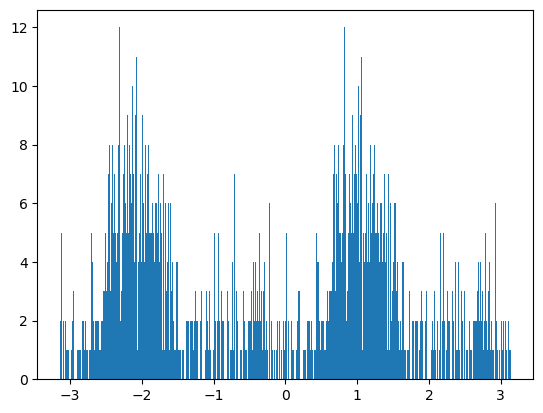

In [30]:
sigma = 8
Ntheta = 500
t = np.arange(Ntheta+1)*(2*np.pi/Ntheta) - np.pi
theta1 = np.pi/3
theta2 = 5*np.pi/6
rng = np.random.default_rng(4)
A_hemi = rng.vonmises(theta1,sigma,500)
B_hemi = rng.vonmises(theta2,4,200)
X_hemi = np.concatenate((A_hemi,B_hemi))
X_flip = np.where(X_hemi <= 0, X_hemi+np.pi, X_hemi-np.pi)
X = np.concatenate((X_hemi,X_flip))

plt.figure()
x,_,_ = plt.hist(X,bins=t)

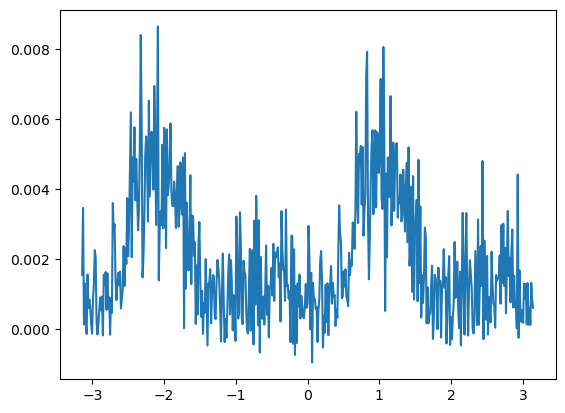

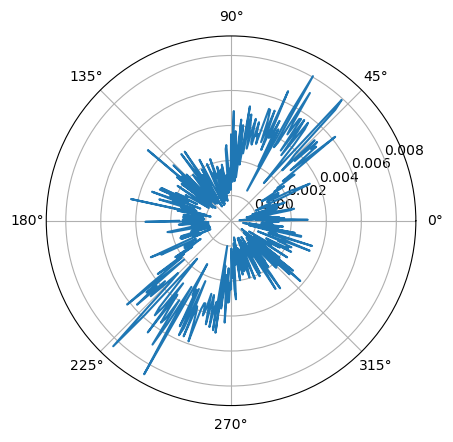

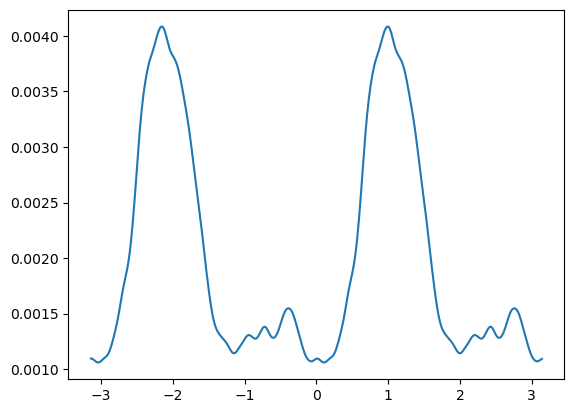

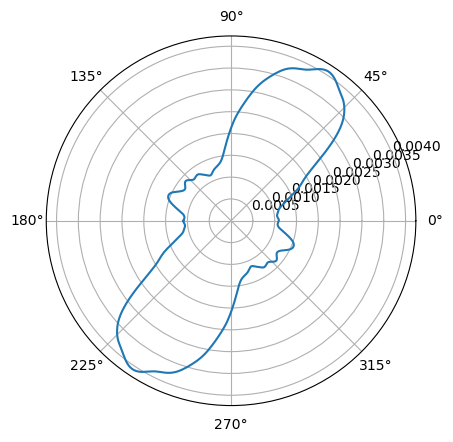

In [36]:
xf = np.fft.rfft(x)
n = np.arange(len(xf))
xf_damped = xf * np.exp(-0.1*n)
xfinv = np.fft.irfft(xf,Ntheta+1)
xfinv = xfinv / np.sum(xfinv)
xfinv_damped = np.fft.irfft(xf_damped,Ntheta+1)
xfinv_damped = xfinv_damped / np.sum(xfinv_damped)
fig, ax = plt.subplots()
plt.plot(t,xfinv)
fig,ax = plt.subplots(subplot_kw={'projection':'polar'})
plt.plot(t,xfinv)
fig, ax = plt.subplots()
plt.plot(t,xfinv_damped)
fig,ax = plt.subplots(subplot_kw={'projection':'polar'})
plt.plot(t,xfinv_damped)

In [4]:
xf.shape

(251,)

/home/brysongray/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


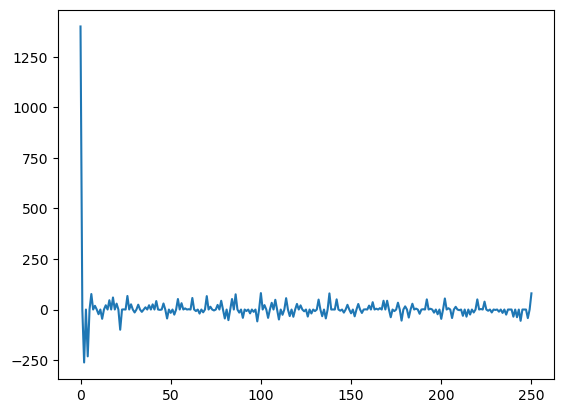

In [6]:
plt.plot(xf)

In [17]:
# xf_damped = gaussian_filter(xf, 3)
t = np.arange(len(xf))
xf_damped = xf * np.exp(-0.01*t)

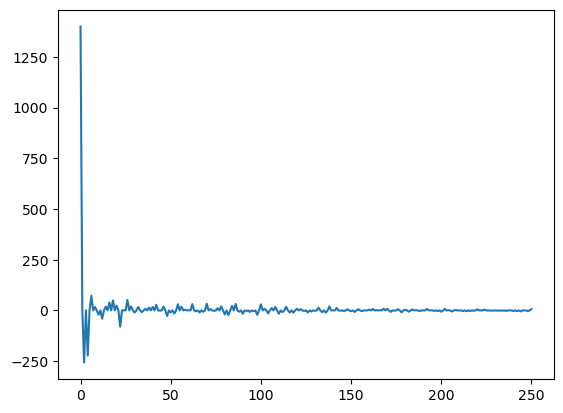

In [18]:
plt.figure()
plt.plot(xf_damped)

Now let's do it in 3D

In [3]:
# first create bins of equal area on a sphere
i = 0
N = 500
a = 4*np.pi/N
d = np.sqrt(a)
M_theta = int(np.rint(np.pi/d))
d_theta = np.pi/M_theta
d_phi = a/d_theta
x = []
for m in range(M_theta):
    theta = np.pi*(m+0.5)/M_theta
    M_phi = int(np.rint(2*np.pi*np.sin(theta)/d_phi))
    for n in range(M_phi):
        phi = 2*np.pi*n/M_phi
        x.append([theta,phi])
        i+=1
print(i)
x = np.transpose(np.array(x))
# count up frequencies from a kent distribution

# approximate the density by fitting spherical harmonics using least squares approximation

500


In [4]:
print(np.min(x[0]),np.max(x[0]))
print(np.min(x[1]),np.max(x[1]))

0.07853981633974483 3.0630528372500483
0.0 6.122077991610879


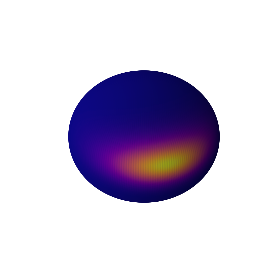

In [5]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sphere.distribution import fb8


def grid(npts):
    return [_.flatten() for _ in np.meshgrid(np.linspace(0, np.pi, npts), np.linspace(0,2*np.pi, npts))]


def plot_fb8(fb8, npts):
    """
    Plot fb8 on 3D sphere
    """
    xs = fb8.spherical_coordinates_to_nu(*grid(npts))
    pdfs = fb8.pdf(xs)
    z,x,y = xs.T #!!! Note the ordering for xs here is used consistently throughout. Follows Kent's 1982 paper.

    fig = plt.figure(figsize=plt.figaspect(1.))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x.reshape(npts, npts),
                    y.reshape(npts, npts),
                    z.reshape(npts, npts),
                    alpha=0.5,
                    rstride=1, cstride=1,
                    facecolors=cm.plasma(pdfs.reshape(npts, npts)/pdfs.max()))
    ax.set_axis_off()
#     plt.tight_layout(-5)
    plt.tight_layout()

    plt.show()


plot_fb8(fb8(np.pi/16,-np.pi/3,0,10,10,-1,0.5,0.3), 200)

In [3]:
# helper functions for visualization
WINDOW_SIZE = (400, 400)
SAVEIM_FOLDER = 'images'
if not os.path.exists(SAVEIM_FOLDER):
    os.mkdir(SAVEIM_FOLDER)

def screenshot_animated_sf(sf, sphere, rot=True, norm=True, scale=True, title='Modeling', theta_step=30):
    '''
    Render a spherical function to file. Returns path to image.
    '''
    
    scene = window.Scene()
    scene.background(window.colors.white)
    
    sf_actor = actor.odf_slicer(sf[None, None, None, :],
                               sphere=sphere, colormap='jet',
                               norm=norm)#, radial_scale=scale)
    if rot:
        sf_actor.RotateX(90)
    scene.add(sf_actor)
    
    images = []
    n_frames = 360//theta_step
    for i in np.arange(n_frames):
#         sf_actor.RotateX(theta_step)
#         sf_actor.RotateY(theta_step)
        sf_actor.RotateZ(theta_step)

        scene.reset_clipping_range()
        images.append(PILImage.fromarray(window.snapshot(scene, size=WINDOW_SIZE)))
        
    frame_duration = 15000 // theta_step
    filename = os.path.join(SAVEIM_FOLDER, '{0}.gif'.format(title))
    images[0].save(filename, save_all=True, append_images=images[1:],
                  duration=frame_duration, optimize=False, loop=0)
    scene.clear()

    return filename
    
def screenshot_gradients(sph_gtab, title='Modeling'):
    scene = window.Scene()
    scene.background(window.colors.white)

    scene.add(actor.point(sph_gtab.vertices, window.colors.green, point_radius=0.05))

    outfile = os.path.join(SAVEIM_FOLDER, '{0}.png'.format(title))
    window.snapshot(scene, size=WINDOW_SIZE, fname=outfile)

    scene.clear()
    return outfile
        

In [4]:
n_pts = 64
bvalue = 1000
theta = np.pi - np.random.rand(n_pts)
phi = 2 * np.pi - np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial,5000)

vertices = hsph_updated.vertices
values = np.ones(vertices.shape[0])
bvecs = np.vstack((vertices))
bvals = np.hstack((bvalue * values))
# add some b=0 bvals/bvecs
bvecs = np.insert(bvecs, (0,bvecs.shape[0]), np.array([0,0,0]), axis = 0)
bvals = np.insert(bvals, (0, bvals.shape[0]), 0)

gtab = gradient_table(bvals, bvecs)
sph_gtab = Sphere(xyz=np.vstack((vertices,-vertices)))

print('bvecs,\n', bvecs)
print('bvals,\n', bvals)


bvecs,
 [[ 0.          0.          0.        ]
 [ 0.82058005  0.30316539  0.48449885]
 [-0.98735634 -0.13579698  0.08177193]
 [-0.17082473  0.31041615  0.93512605]
 [-0.18875955 -0.39623631  0.89853582]
 [-0.54411658  0.80642317  0.23155737]
 [-0.65833923  0.29380854  0.69301226]
 [-0.75778288 -0.30969033  0.57433179]
 [-0.16645135  0.66996058  0.72349621]
 [-0.90055691 -0.30950503  0.3052931 ]
 [-0.46947138 -0.39671318  0.78880624]
 [ 0.36189972  0.52964425  0.76714116]
 [ 0.97279315 -0.19249922  0.128909  ]
 [ 0.49183054 -0.46985701  0.73303282]
 [-0.13496378  0.02987376  0.99040009]
 [ 0.97039684  0.09306701  0.22286433]
 [-0.01227872  0.88715449  0.46130917]
 [ 0.1024447   0.23185063  0.96734191]
 [ 0.68040017 -0.73120217  0.04897955]
 [ 0.61550798  0.16000074  0.77171866]
 [-0.6528782   0.61585178  0.44099506]
 [ 0.27454756 -0.01339499  0.96148022]
 [ 0.72204887 -0.40099087  0.56378343]
 [ 0.85542408 -0.02646377  0.5172517 ]
 [-0.76891885 -0.63659574  0.05924247]
 [-0.49860748  0.

In [5]:
sph_gtab.vertices.shape

(128, 3)

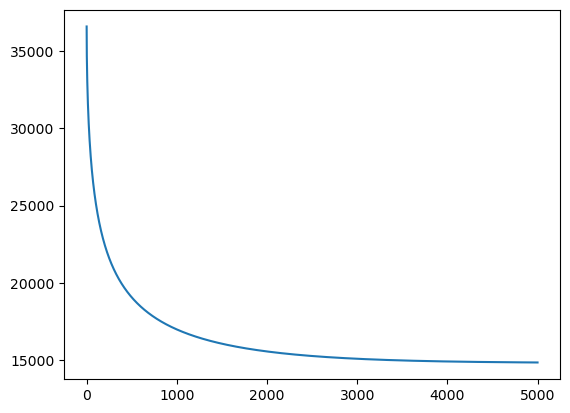

In [6]:
plt.figure()
plt.plot(potential)

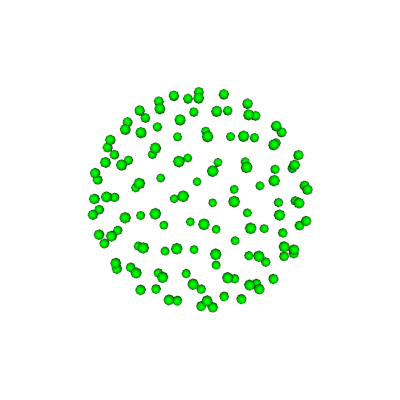

In [11]:
image = screenshot_gradients(sph_gtab, title='Example directions')
Image(filename=image)

In [22]:
S0 = 100
SNR = 500
N = 2 # number of fibers
if N == 1:
    mevals = np.array([[0.0015, 0.0004, 0.0004]])
    angles = [(0, 0)]
    fractions = [100]
elif N == 2:
    separation_angle = 90 # angle between fibers
    mevals = np.array([[0.0015, 0.0004, 0.0004],
                       [0.0015, 0.0004, 0.0004]])
    angles = [(90, 0), (separation_angle, 90)]
    fractions = [50, 50]
elif N == 3:
    mevals = np.array([[0.0015, 0.0004, 0.0004],
                       [0.0004, 0.0015, 0.0004],
                       [0.0004, 0.0004, 0.0015]])
    angles = [(0, 0), (90, 0), (0,90)]
    fractions = [33, 33, 34]
else:
    raise ValueError('Inavalid number of fibers ')
    
# signal, sticks = multi_tensor(gtab, mevals, S0=S0, angles=angles,
#                               fractions=fractions, snr=SNR)
signal = multi_tensor_odf(gtab.bvecs, mevals, angles=angles,
                              fractions=fractions)

print(signal)

[       inf 0.07986325 0.15594895 0.04415869 0.04606403 0.08397015
 0.05913233 0.06957137 0.05858407 0.10255987 0.05146282 0.0529326
 0.14278178 0.05431855 0.04153249 0.14010877 0.09527902 0.04261082
 0.08162486 0.05461883 0.06955189 0.04292711 0.06712747 0.08570063
 0.08307057 0.05865036 0.0465492  0.11628649 0.05780192 0.16791799
 0.04200224 0.07486966 0.0817261  0.05769484 0.06915269 0.07300641
 0.08094299 0.08625911 0.05881091 0.08445476 0.0612946  0.09466857
 0.07547838 0.05491354 0.08450869 0.04691335 0.06884348 0.04473705
 0.06405687 0.13437944 0.14205798 0.04683106 0.09197008 0.0486644
 0.11356325 0.09268827 0.12849316 0.09629472 0.04945376 0.10654624
 0.04923925 0.06666788 0.06098056 0.11725901 0.07451095        inf]


In [31]:
sph_gtab.vertices.shape

(128, 3)

In [27]:
# generate an antipodally symmetric spherical function from our signal

signal_sph = np.zeros(vertices.shape[0]*2)
signal_sph[0:vertices.shape[0]] = signal[1:-1]
signal_sph[vertices.shape[0]:] = signal[1:-1]

image = screenshot_animated_sf(signal_sph, sph_gtab, False, False, True,
                               title='Simulated tensor with {} fiber(s), unscaled'.format(N), theta_step=360)
Image(filename=image)

In [12]:
signal_sph

array([0.07986325, 0.15594895, 0.04415869, 0.04606403, 0.08397015,
       0.05913233, 0.06957137, 0.05858407, 0.10255987, 0.05146282,
       0.0529326 , 0.14278178, 0.05431855, 0.04153249, 0.14010877,
       0.09527902, 0.04261082, 0.08162486, 0.05461883, 0.06955189,
       0.04292711, 0.06712747, 0.08570063, 0.08307057, 0.05865036,
       0.0465492 , 0.11628649, 0.05780192, 0.16791799, 0.04200224,
       0.07486966, 0.0817261 , 0.05769484, 0.06915269, 0.07300641,
       0.08094299, 0.08625911, 0.05881091, 0.08445476, 0.0612946 ,
       0.09466857, 0.07547838, 0.05491354, 0.08450869, 0.04691335,
       0.06884348, 0.04473705, 0.06405687, 0.13437944, 0.14205798,
       0.04683106, 0.09197008, 0.0486644 , 0.11356325, 0.09268827,
       0.12849316, 0.09629472, 0.04945376, 0.10654624, 0.04923925,
       0.06666788, 0.06098056, 0.11725901, 0.07451095, 0.07986325,
       0.15594895, 0.04415869, 0.04606403, 0.08397015, 0.05913233,
       0.06957137, 0.05858407, 0.10255987, 0.05146282, 0.05293

In [13]:
from dipy.reconst.shm import sh_to_sf_matrix, sh_to_sf

print('Building SH matrix of order 8')
B, invB = sh_to_sf_matrix(sph_gtab, 8)
print('Shape,', B.shape, '\n')

print('Building high resolution SH matrix of order 8')
sphere = get_sphere('symmetric724')
sphere = sphere.subdivide(2)
B_highres, invB_highres = sh_to_sf_matrix(sphere, 8)
print('Shape: ', B_highres.shape)

Building SH matrix of order 8
Shape, (45, 128) 

Building high resolution SH matrix of order 8
Shape:  (45, 11554)


In [14]:
print('Estimate SH coefficients of the signal')
# S = B*sh_signal => sh_signal = invB * S
sh_signal = np.dot(invB.T, signal_sph)
print('SH signal shape, ', sh_signal.shape, '\n')
print('Project back SH coefficient to the high resolution sphere')
signal_sphere = np.dot(sh_signal, B_highres)
print('SF signal shape: ', signal_sphere.shape)


Estimate SH coefficients of the signal
SH signal shape,  (45,) 

Project back SH coefficient to the high resolution sphere
SF signal shape:  (11554,)


In [15]:
x1 = Sphere(theta=np.pi/4, phi=0) # the input direction needs to be a dipy sphere object
x2 = Sphere(x=np.sqrt(2)/2, y=0, z=-np.sqrt(2)/2)
y1 = sh_to_sf(sh_signal, x1, sh_order=8) # sample from odf
y2 = sh_to_sf(sh_signal, x2, sh_order=8)
y3 = sh_to_sf(sh_signal, sphere, sh_order=8)
print(y1)
print(y2)
print(np.max(y3))

[0.06158325]
[0.0615242]
0.16810700563098546


In [16]:
print(np.cos(np.pi/4))
print(np.sqrt(2)/2)

0.7071067811865477
0.7071067811865476


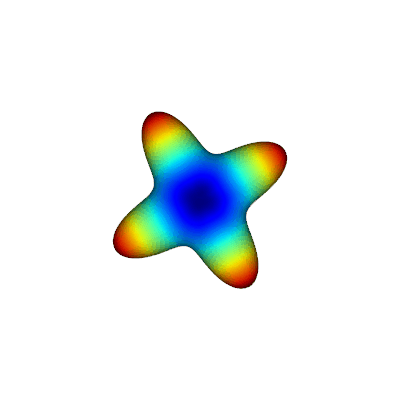

In [17]:
image = screenshot_animated_sf(signal_sphere, sphere, title='multi-tensor odf signal', theta_step=30, rot=False)

Image(filename=image)

In [18]:
np.max(signal_sphere)


0.16810700563098546

In [21]:
cf = diffusion.sh_to_cf(sh_signal, 100, 64)
# cf_scaled = odfs.sh_to_cf(sh_signal, 100, 64, norm=False)

spherical harmonic degree is 8.
computing a new basis...


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:35<00:00,  7.04s/it]

done


TypeError: expected str, bytes or os.PathLike object, not int

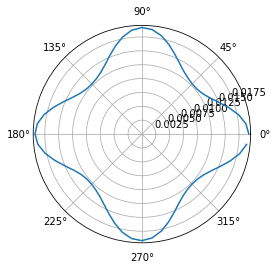

In [85]:
nbins = 64
step = 2*np.pi/nbins
bins = np.arange(0,2*np.pi,step)

fig, ax = plt.subplots(subplot_kw={'projection':'polar'})
plt.plot(bins,cf)
plt.savefig('/home/brysongray/dti_validate/notebooks/images/multi-tensor_odf_signal_to_2d')

In [32]:
np.sum(cf)

1.0

/home/brysongray/anaconda3/lib/python3.9/site-packages/dipy/reconst/shm.py:985: RuntimeWarning: invalid value encountered in true_divide
  out /= b0[..., None]


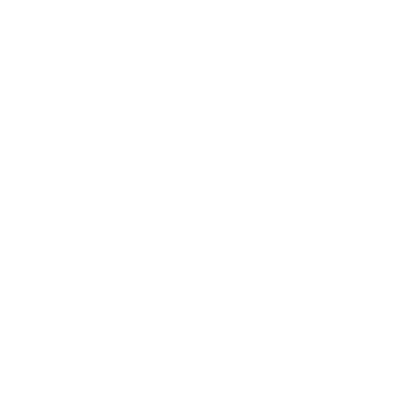

In [33]:
from dipy.reconst.shm import CsaOdfModel, QballModel

qball_model = QballModel(gtab, 8)
fit = qball_model.fit(signal)
# csa_model = CsaOdfModel(gtab,8)
# fit = csa_model.fit(signal)
odf = fit.odf(sphere)

image = screenshot_animated_sf(odf, sphere, title='Q-ball model orientation probabilities')

Image(filename=image)

In [59]:
signal

array([       inf, 0.04966975, 0.09077516, 0.10973648, 0.16232821,
       0.06682471, 0.16493102, 0.04679834, 0.0640839 , 0.05085534,
       0.10780724, 0.13792491, 0.09343197, 0.13897634, 0.10575724,
       0.07350616, 0.05709934, 0.08786403, 0.08822582, 0.06136707,
       0.08366639, 0.0847549 , 0.0552831 , 0.11912368, 0.0678193 ,
       0.08334993, 0.04679843, 0.04874115, 0.04221144, 0.05757698,
       0.07680784, 0.10908255, 0.09226323, 0.04387113, 0.07544888,
       0.12165411, 0.07398351, 0.0611029 , 0.04402544, 0.11891781,
       0.06022979, 0.05908395, 0.06744899, 0.09496907, 0.08501357,
       0.04834179, 0.04502655, 0.06239607, 0.04236527, 0.04709907,
       0.05997912, 0.07450653, 0.10205415, 0.07239467, 0.14014985,
       0.0882861 , 0.07923688, 0.13778826, 0.05205868, 0.04147373,
       0.0556651 , 0.07915277, 0.07418   , 0.05288897, 0.0783381 ,
              inf])